In [12]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from tqdm import tqdm
from matplotlib import font_manager
font_family = font_manager.FontProperties(fname='C:/Windows/Fonts/malgunsl.ttf').get_name()
plt.rc('font', family=font_family)

In [13]:
def get_url(sDt, eDt, nRow = 10):
    
    nRow = 5
    sDt = pd.to_datetime(sDt) - timedelta(days=1)
    sDt = sDt.strftime('%Y%m%d')
    #print(sDt)
    ukey = 'zEFO7vnEr%2B2Hu8fWds8Xjb5nL6L3K4aOYNDrnV7SIC7hze757HLrk5IZs694GFsWnj6f7J2vHOJgTFUa%2BHVhww%3D%3D'
    url =  'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19GenAgeCaseInfJson?serviceKey='+ukey
    url = url + '&pageNo=1&numOfRows='+str(nRow)+'&startCreateDt='+str(sDt)+'&endCreateDt='+str(eDt)
    
    xml_soup = requests.get(url)
    soup = []
    if xml_soup.status_code == 200:
        soup = bs(xml_soup.text,'html.parser')
    else:
        raise Excotion("Error Code:"+str(xml_soup.status_code))
        exit()
    return soup
#get_url(sDt = 20210101 , eDt = 20210201)

# 코로나 정보 가져오기
def covid_info(soup, ip):
    
    # 코로나 API가져오기 : 기본자료 데이터프레임 생성
    items = soup.find_all('item')
    covid_lst=[]
    for item in tqdm(items, desc='진행률='):

        if ip == item.find('gubun').get_text():
            cDt = datetime.strptime(item.find('createdt').get_text()[:10].replace('-',""), "%Y%m%d")
            #print(cDt)
            guBun = item.find('gubun').get_text()
            confCase = int(item.find('confcase').get_text())
            death = int(item.find('death').get_text())

            covid_lst.append({'등록일' : cDt, '구분' : guBun, '확진자' : confCase, '사망자' : death})

    df1 = pd.DataFrame(covid_lst)
    df1.sort_values(by='등록일', inplace = True)
    df1 = df1.reset_index(drop=True)
    
    # 필요 정보 추가하고 재정비한 데이터프레임 생성
    covid_lst_new = []
    for i in range(1, len(df1)):
        dt = df1.iloc[i][0]
        gu = df1.iloc[i][1]
        conf = df1.iloc[i][2]-df1.iloc[i-1][2]
        tconf = df1.iloc[i][2]
        death = df1.iloc[i][3]-df1.iloc[i-1][3]
        tdeath = df1.iloc[i][3]

        covid_lst_new.append({'등록일' : dt, '구분' : gu, '당일확진자' : conf , '누적확진자' : tconf , '사망자' : death, '누적사망자' : tdeath })
    df2 = pd.DataFrame(covid_lst_new)
    return df2

#그래프 시각화
def plot_show(num, ip="", df=""):
    if num == 1:
        plt.style.use('ggplot')
        plt.figure(figsize = (15,7))
        plt.title( ip + '세 확진자 추이', size = 20)
        plt.plot( df['등록일'], df['당일확진자'], label= ip)
        plt.legend
        plt.show()
        return plt.show()

    if num == 2:
        plt.style.use('ggplot')
        plt.figure(figsize = (15,7))
        plt.title( ip + ' 확진자 추이', size = 20)
        plt.plot( df['등록일'], df['당일확진자'], label= ip)
        plt.legend
        plt.show()
        return plt.show()
    
def covid_info_add(soup):
    
    # 코로나 API가져오기 : 기본자료 데이터프레임 생성
    items = soup.find_all('item')
    covid_lst=[]
    index_ADD= ['0-9', '10-19', '20-29', '30-39', '40-49','50-59','60-69','70-79','80 이상', '남성', '여성']
    df1 = pd.DataFrame()
    df = pd.DataFrame()
    for ip in tqdm(index_ADD, desc='진행률='):
        for item in items:

            if ip == item.find('gubun').get_text():
                cDt = datetime.strptime(item.find('createdt').get_text()[:10].replace('-',""), "%Y%m%d")
                #print(cDt)
                guBun = item.find('gubun').get_text()
                confCase = int(item.find('confcase').get_text())
                death = int(item.find('death').get_text())

                covid_lst.append({'등록일' : cDt, '구분' : guBun, '확진자' : confCase, '사망자' : death})
        df = pd.DataFrame(covid_lst)
        df.sort_values(by='등록일', inplace = True)
        df = df.reset_index(drop=True)
        covid_lst_new = []
        for i in range(1, len(df)):
            dt = df.iloc[i][0]
            conf = df.iloc[i][2]-df.iloc[i-1][2]
            tconf = df.iloc[i][2]
            death = df.iloc[i][3]-df.iloc[i-1][3]
            tdeath = df.iloc[i][3]

            covid_lst_new.append({'등록일' : dt, ip : conf })
            df2 = pd.DataFrame(covid_lst_new)
        if ip =='0-9':
            df1 = df2
        else:
            df1= pd.merge(df1, df2 ,on = '등록일')
        covid_lst= []

 
    return df1
def main():
    while True:
        sDt = input('시작 날짜를 입력하세요. ex)20200402')
        if len(sDt) != 8:
            print('20200402와 같이 8자리로 입력해주세요')
            continue
        try:
            dt = pd.to_datetime(sDt)
            sd = int(sDt)
            if sd < 20200402:
                print('해당 데이터는 20200402일 이후 자료만 제공됩니다..\n다시 입력해주세요')
                continue
            break
        except:
            print('날짜를 잘못 입력하셨습니다. 입력 날짜를 확인해주세요.')
            continue

    while True:
        eDt = input('종료 날짜를 입력하세요. ex)20210101')
        if len(eDt) != 8:
            print('20200402와 같이 8자리로 입력해주세요')
            continue
        try:
            dt = pd.to_datetime(eDt)
            sd = int(eDt)
            newDate = datetime.today().strftime('%Y%m%d')
            if sd>= int(newDate):
                print('데이터는 당일자료까지만 입력됩니다.\n 다시입력해주세요')
                continue

            if int(sDt)> sd:
                print('종료일이 시작일보다 이전 날짜입니다. \n 다시입력해주세요')
                continue
            break
        except:
            print('날짜를 잘못 입력하셨습니다. 입력 날짜를 확인해주세요.')
            continue

    while True:
        q = input('연령별 조회 : 1, 성별 조회 : 2, 일자별 현황표 : 3를 누르세요')
        if q =="1":
            index_A= ['0-9', '10-19', '20-29', '30-39', '40-49','50-59','60-69','70-79','80 이상'] 
            ip = input('조회할 연령대를 입력하세요. ex)0-9, 10-19' )
            
            if ip not in index_A:
                print('연령 범위를 확인 후 다시 입력해주세요.')
                continue
            
            else:
                num = 1
                break
        elif q=="2":
            index_S = ['남성','여성']
            ip = input('입력할 성별을 입력하세요. ex)남성, 여성')
            
            if ip not in index_S:
                print('조회할 성별을 다시 입력해주세요.')
                continue
            else:
                num = 2
                
                break
        elif q=="3":
            num = 3
            soup = get_url(sDt,eDt)
            df1= covid_info_add(soup)
            print(df1)
            break
        
        else:
            print('잘못 입력하셨습니다. \n다시 입력해주세요.')
            continue
    if num ==1 or num ==2 :
        soup = get_url(sDt,eDt)
        df = covid_info(soup, ip)
        result = plot_show(num, ip, df)

시작 날짜를 입력하세요. ex)2020040220210101
종료 날짜를 입력하세요. ex)2021010120210712
연령별 조회 : 1, 성별 조회 : 2, 일자별 현황표 : 3를 누르세요2
입력할 성별을 입력하세요. ex)남성, 여성남성


진행률=: 100%|██████████████████████████████████████████████████████████████████| 2142/2142 [00:00<00:00, 22825.01it/s]


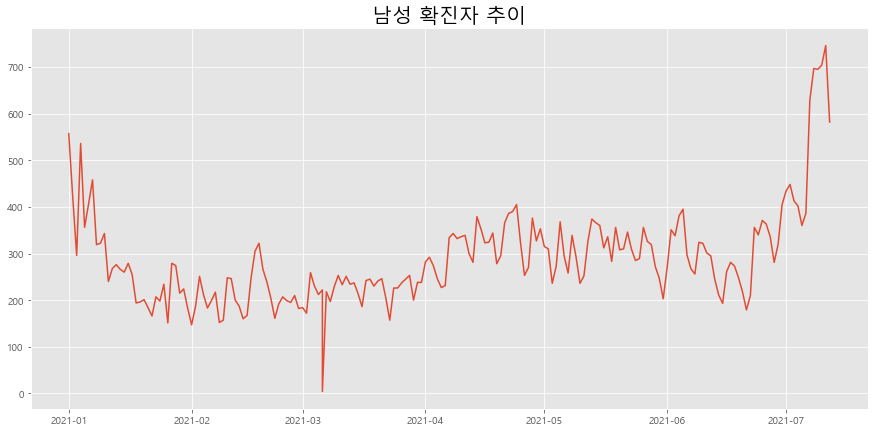

In [16]:
if __name__ == '__main__':
    show = main()